#### Setup

In [130]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import os
import re
import json
import psycopg2
from sqlalchemy.engine.url import URL

# connection to the database
# connection string for use in pandas:
con = str(URL(drivername='postgresql', 
              username=os.environ['DB_QIR_USERNAME'], 
              password=os.environ['DB_QIR_PASSWORD'], 
              host='www.quantleap.nl', 
              database='qir'))

# cursor for use with psycopg2
conn = psycopg2.connect(con)
cur = conn.cursor()  
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Report data set description

The data set used in this study contains all the PDF reports published in 2017.

There are two types of reports: 
1. progress reports, containing text based on a RECOFA template
2. financial reports, containing tables - [todo: determine conformance with RECOFA template]

Most often [todo: measure] the financial reports are attached to a progress report: both are published on the same date and the identification number is equal, only the financial report has '\_B' as a postfix.

Initially we will be focussing on the progress reports as these have more structure and contain more of the data we want to retreive to answer the research questions.

## report publication over time
An overview is given on the published reports over time in the CIR register. From 2014 onwards it shows a steady flow of reports and the trend of a larger portion of financial reports attached to the progress reports, although it has not reached 100% (same amount of both progress and financial reports).

For the purpose of this study the progress reports published in 2017 will be used.

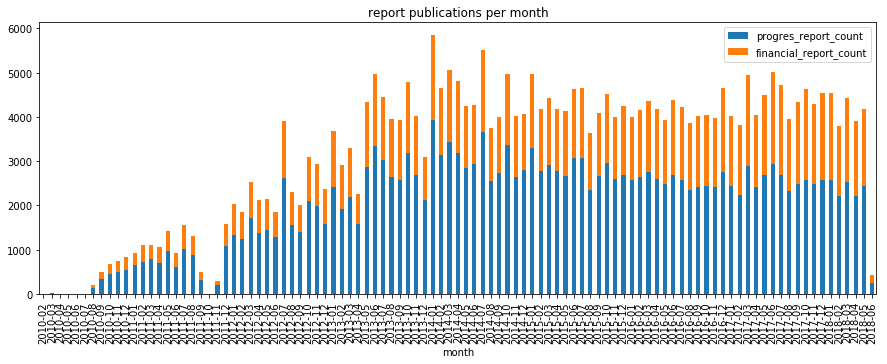

In [131]:
sql = """
with
financial as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as financial_report_count
      from reports
      where right(identification, 1) = 'B'
      group by 1),
progress as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as progres_report_count
      from reports
      where right(identification, 1) != 'B'
      group by 1)
select prog.month, progres_report_count, coalesce(financial_report_count, 0) as financial_report_count
  from financial fin
    full outer join progress prog on fin.month = prog.month
  order by prog.month;
"""
df = pd.read_sql(sql, con, index_col="month")
df.plot.bar(stacked=True, figsize=(15, 5), title='report publications per month')

# Completeness checks
A subselection of the published reports will be used for analysis:
- reports from 2017
- downloaded PDF reports (some cannot be downloaded anymore)
- converted instead of scanned PDFs 
- reports with extracted text (some PDF reports are encrypted or damaged (absent End of Image / End of File) and text cannot be extracted)

## PDF reports downloaded

In [80]:
sql = '''select identification, is_ocr, is_on_disk, publication_date, is_extractable
         from reports 
         where extract(year from publication_date) >= 2014
             and extract(year from publication_date) <= 2017
             and is_attachment=False;'''
df = pd.read_sql(sql, con, index_col='publication_date')

print('The dataset to be used contains {} progress reports in period 2014 - 2017'.format(len(df)))
df.head()

The dataset to be used contains 132457 progress reports in period 2014 - 2017


,identification,is_ocr,is_on_disk,is_extractable
publication_date,,,,
2017-05-10 16:15:08,17_nne_17_4_F_V_04,False,True,True
2014-01-30 14:25:52,07_ove_12_173_F_V_04,True,True,True
2014-03-25 16:33:10,02_zwb_10_280_F_V_12,True,True,True
2017-06-19 16:25:18,16_mne_15_695_F_V_09,False,True,True
2016-07-01 10:22:04,15_nho_15_119_F_V_04,False,True,True


In [81]:
total = df['identification'].resample('M').count()
total

publication_date
2014-01-31    3923
2014-02-28    3138
2014-03-31    3441
2014-04-30    3195
2014-05-31    2843
2014-06-30    2944
2014-07-31    3662
2014-08-31    2548
2014-09-30    2739
2014-10-31    3359
2014-11-30    2634
2014-12-31    2793
2015-01-31    3295
2015-02-28    2782
2015-03-31    2922
2015-04-30    2783
2015-05-31    2663
2015-06-30    3066
2015-07-31    3078
2015-08-31    2342
2015-09-30    2671
2015-10-31    2966
2015-11-30    2589
2015-12-31    2696
2016-01-31    2564
2016-02-29    2641
2016-03-31    2766
2016-04-30    2602
2016-05-31    2485
2016-06-30    2693
2016-07-31    2574
2016-08-31    2338
2016-09-30    2408
2016-10-31    2438
2016-11-30    2421
2016-12-31    2750
2017-01-31    2430
2017-02-28    2232
2017-03-31    2886
2017-04-30    2426
2017-05-31    2684
2017-06-30    2942
2017-07-31    2682
2017-08-31    2319
2017-09-30    2480
2017-10-31    2581
2017-11-30    2479
2017-12-31    2564
Freq: M, Name: identification, dtype: int64

In [82]:
df_on_disk = df[df.is_on_disk == True]
on_disk = df_on_disk.is_on_disk.resample('M').count()
on_disk

publication_date
2014-01-31    3923
2014-02-28    3138
2014-03-31    3440
2014-04-30    3195
2014-05-31    2843
2014-06-30    2944
2014-07-31    3662
2014-08-31    2548
2014-09-30    2739
2014-10-31    3355
2014-11-30    2634
2014-12-31    2793
2015-01-31    3295
2015-02-28    2782
2015-03-31    2922
2015-04-30    2783
2015-05-31    2663
2015-06-30    3066
2015-07-31    3078
2015-08-31    2339
2015-09-30    2670
2015-10-31    2966
2015-11-30    2589
2015-12-31    2696
2016-01-31    2564
2016-02-29    2641
2016-03-31    2690
2016-04-30    2599
2016-05-31    2479
2016-06-30    2645
2016-07-31    2569
2016-08-31    2328
2016-09-30    2374
2016-10-31    2409
2016-11-30    2411
2016-12-31    2376
2017-01-31       2
2017-02-28    1248
2017-03-31    2886
2017-04-30    2426
2017-05-31    2684
2017-06-30    2942
2017-07-31    2682
2017-08-31    2319
2017-09-30    2480
2017-10-31    2581
2017-11-30    1458
2017-12-31    2564
Freq: M, Name: is_on_disk, dtype: int64

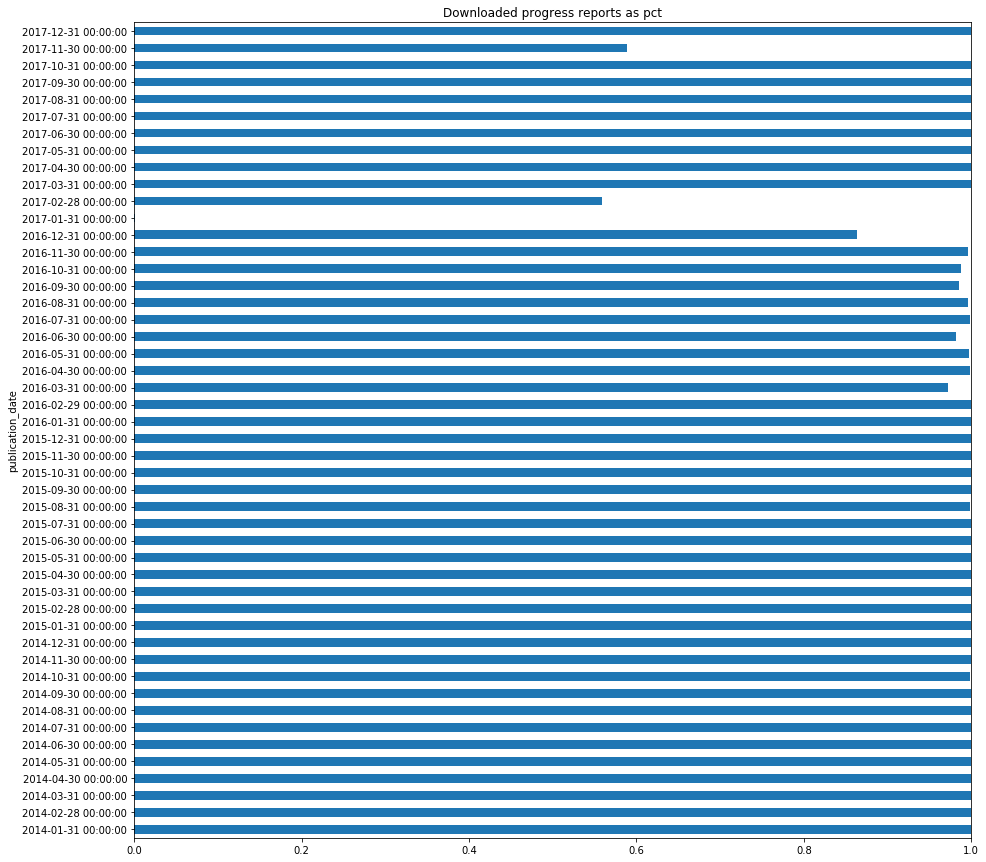

In [97]:
(on_disk / total).plot.barh(title='Downloaded progress reports as pct', xlim=[0,1], figsize=(15, 15))

Results: not all reports are downloaded/retrieved for the 2017 dataset. Effort will be put into making this set complete. As can be seen specific periods are omitted.

## PDF Conversion of progress reports on disk

PDFs can be generated by:
1. scanning printed pages - resulting in an image only document, 
2. converting a document to PDF - resulting in a text only document
3. scanning printed pages with OCR (Optical Character Recognition) - resulting in a text and image document

The latter one can have discrepancies between the visible text and extracted text.

In [88]:
df_on_disk_and_not_scanned = df_on_disk[df_on_disk.is_ocr == False]
on_disk_and_not_scanned = df_on_disk_and_not_scanned['is_ocr'].resample('M').count()
on_disk_and_not_scanned

publication_date
2014-01-31    1491
2014-02-28    1287
2014-03-31    1269
2014-04-30    1175
2014-05-31    1147
2014-06-30    1115
2014-07-31    1600
2014-08-31    1082
2014-09-30    1115
2014-10-31    1448
2014-11-30    1109
2014-12-31    1146
2015-01-31    1598
2015-02-28    1222
2015-03-31    1246
2015-04-30    1106
2015-05-31    1247
2015-06-30    1455
2015-07-31    1407
2015-08-31    1153
2015-09-30    1267
2015-10-31    1471
2015-11-30    1396
2015-12-31    1359
2016-01-31    1467
2016-02-29    1524
2016-03-31    1626
2016-04-30    1540
2016-05-31    1492
2016-06-30    1791
2016-07-31    1736
2016-08-31    1553
2016-09-30    1685
2016-10-31    1778
2016-11-30    1857
2016-12-31    1868
2017-01-31       1
2017-02-28     954
2017-03-31    2337
2017-04-30    2130
2017-05-31    2295
2017-06-30    2610
2017-07-31    2316
2017-08-31    2100
2017-09-30    2216
2017-10-31    1854
2017-11-30    1231
2017-12-31    2282
Freq: M, Name: is_ocr, dtype: int64

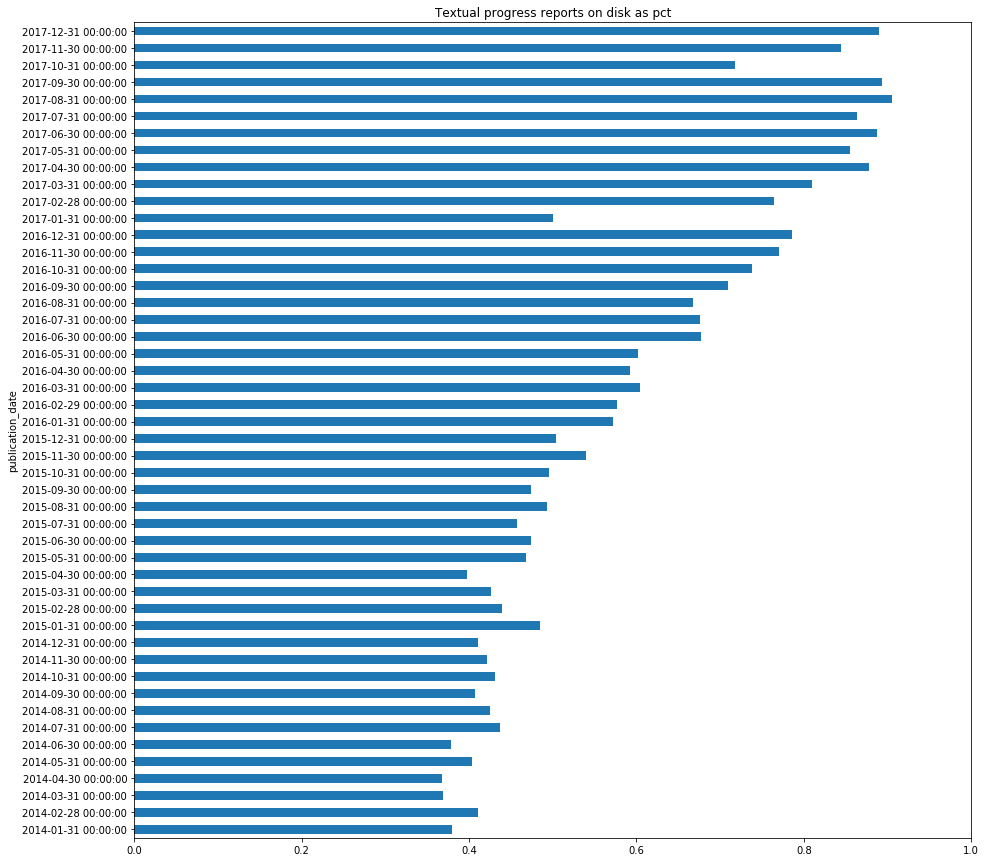

In [98]:
(on_disk_and_not_scanned / on_disk).plot.barh(title='Textual progress reports on disk as pct', xlim=[0,1], figsize=(15, 15))

## Textual progress reports on disk with extracted text

In [90]:
df_is_extractable = df_on_disk_and_not_scanned[df_on_disk_and_not_scanned.is_extractable == True]
is_extractable = df_is_extractable.is_extractable.resample('M').count()
is_extractable

publication_date
2014-01-31    1480
2014-02-28    1281
2014-03-31    1250
2014-04-30    1157
2014-05-31    1121
2014-06-30    1083
2014-07-31    1585
2014-08-31    1058
2014-09-30    1098
2014-10-31    1430
2014-11-30    1080
2014-12-31    1130
2015-01-31    1574
2015-02-28    1204
2015-03-31    1222
2015-04-30    1090
2015-05-31    1229
2015-06-30    1437
2015-07-31    1380
2015-08-31    1138
2015-09-30    1252
2015-10-31    1453
2015-11-30    1369
2015-12-31    1345
2016-01-31    1459
2016-02-29    1510
2016-03-31    1619
2016-04-30    1528
2016-05-31    1486
2016-06-30    1784
2016-07-31    1715
2016-08-31    1545
2016-09-30    1671
2016-10-31    1771
2016-11-30    1845
2016-12-31    1864
2017-01-31       1
2017-02-28     944
2017-03-31    2327
2017-04-30    2120
2017-05-31    2288
2017-06-30    2597
2017-07-31    2289
2017-08-31    2091
2017-09-30    2210
2017-10-31    1848
2017-11-30    1223
2017-12-31    2271
Freq: M, Name: is_extractable, dtype: int64

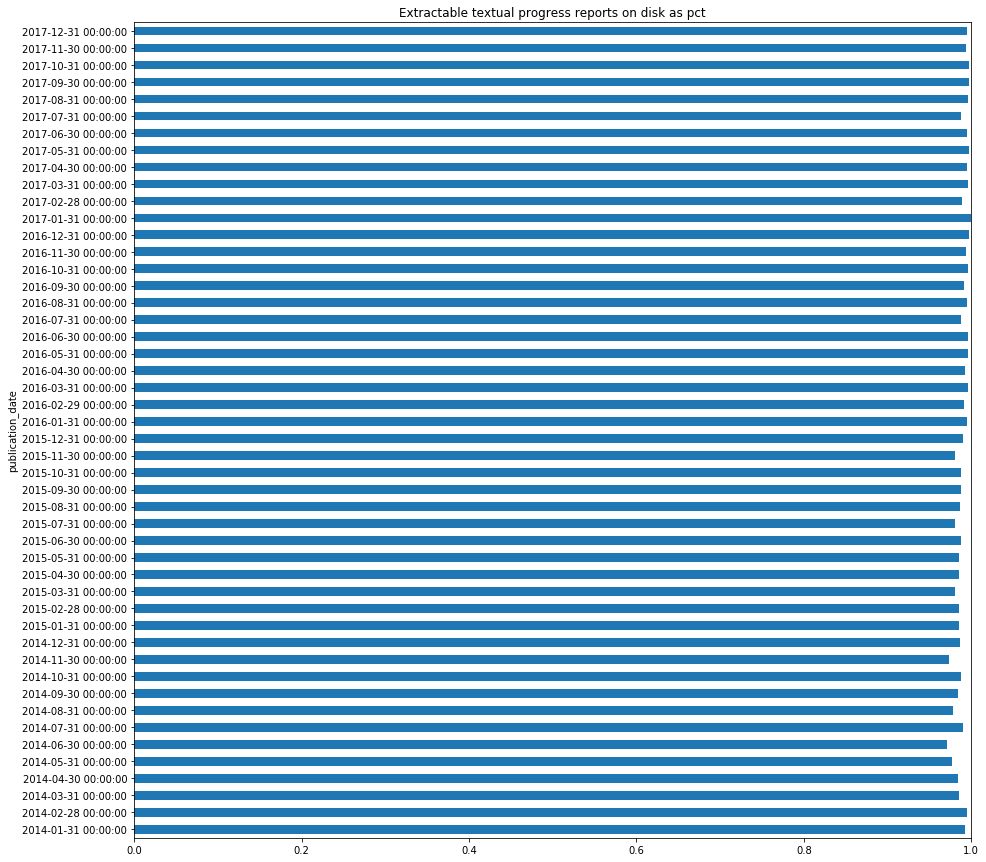

In [99]:
(is_extractable / on_disk_and_not_scanned).plot.barh(title='Extractable textual progress reports on disk as pct', xlim=[0,1], figsize=(15, 15))

### Completeness total funnel

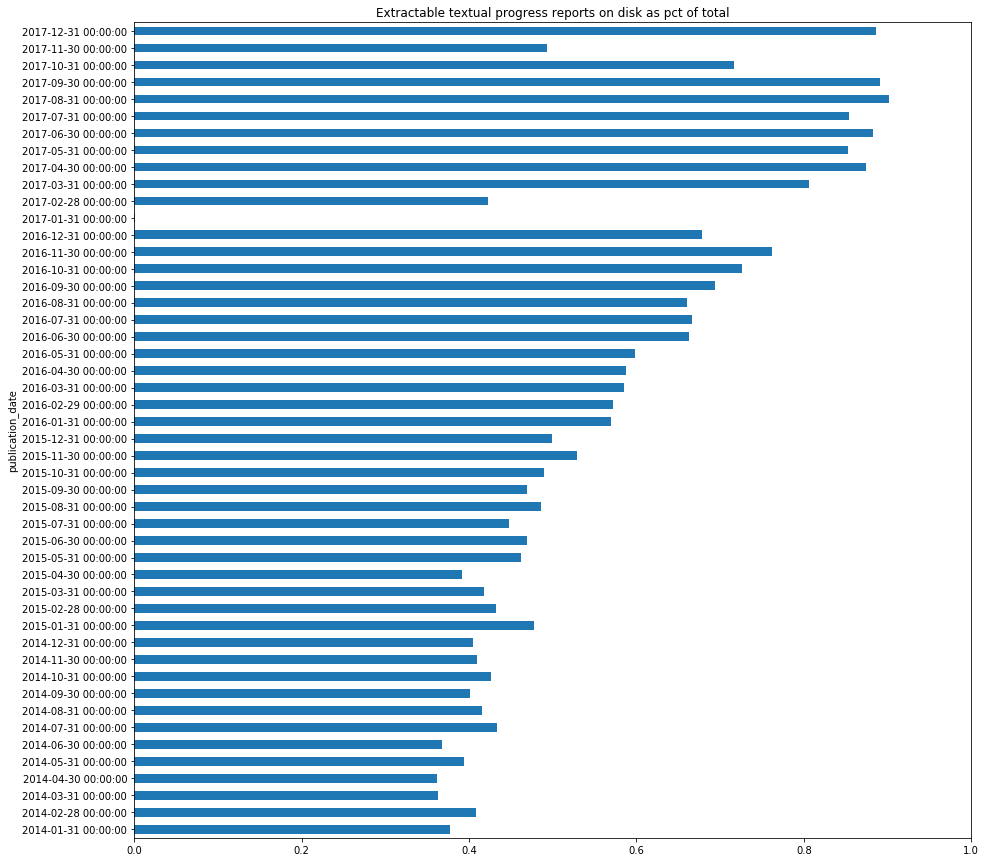

In [100]:
(is_extractable / total).plot.barh(title='Extractable textual progress reports on disk as pct of total', xlim=[0,1], figsize=(15, 15))

## Search in progress reports.

There are three search objectives, each more scoped: 
1. to enable full text search over the whole report
2. to enable faceted search by heading section
3. to extract specific data points as value. 

### Full Text Search
The extracted contents is made searchable using the postgres full text search functionality. (https://www.postgresql.org/docs/9.6/static/textsearch.html)

### Faceted search
The progress reports should be structured in sections according to RECOFA guidelines, see **model-verslag-faillissement-rechtspersoon.pdf**. We like to be able to specificly perform full text search in one of the sections.

### data points wish list
We like to extract specific data point values from the reports. A wish list is given below:

Algemeen
- Personeel gemiddeld aantal: **aantal**
- Bestede uren totaal: **aantal**
- Saldo boedelrekening: **bedrag**


4 Debiteuren

4.2 Opbrengst: **bedrag**


7 Rechtmatigheid

7.2 Depot jaarrekeningen: **wel/niet**

7.5 Onbehoorlijk bestuur: **wel/niet**


8 Crediteuren

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: **bedrag**

8.3 Preferente vorderingen van het UWV: **bedrag**

8.4 Andere preferente vorderingen: **bedrag**

8.5 Aantal concurrente crediteuren: **bedrag**

8.6 Bedrag concurrente crediteuren: **bedrag**

#### Enige terloopse bevindingen en issues
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?
- Strikethrough in PDF komt niet terug in de tekstconversie en dit betekent vaak het tegenovergestelde.
- PDFMiner wisselt soms woordvolgorde en mangled soms letters ook al staat dit duidelijk in het PDF. Dit komt door het formaat: text plus image overlay.
- PyPDF2 hangt op grote images (voorbeelden '16_mne_13_935_F_V_13', '16_mne_13_1055_F_V_13', '16_mne_12_331_F_V_15', '16_mne_12_326_F_V_15', '16_mne_12_327_F_V_15,' '16_mne_12_384_F_V_15') - een pull request #329 fixt dit.

### Faceted search - section extraction
The RECOFA model progress report contains the following sections to be extracted:

Step 1: extract section anchor points from progress reports, the level 2 headings
To extract the introduction we can extract between the beginning and level 1 heading 1.

Step 2: extract candidate sections from model report

In [138]:
sql = '''SELECT identification, content
         FROM reports 
         WHERE extract(year from publication_date) >= 2014
             AND extract(year from publication_date) <= 2017
             AND is_attachment = FALSE
             AND is_ocr = FALSE 
             AND is_extractable = TRUE
             AND content IS NOT NULL
         LIMIT 10;'''
df = pd.read_sql(sql, con, index_col='identification')
df.head(n=10)

,content
identification,
02_zwb_12_787_F_V_11,Openbaar faillissementsverslag rechtspersoon (...
13_ams_14_467_F_V_02,\n\nTWEEDE OPENBAAR VERSLAG \n\nEX ARTIKEL 7...
04_lim_13_322_F_V_02,EERSTE BOEDELVERSLAG \n\nDatum: 14 januari ...
18_nne_13_240_F_V_13,TRI P \n\nDit vers/ag is identiek aan het dig...
08_ove_16_468_F_V_07,Openbaar faillissementsverslag rechtspersoon (...
01_obr_14_943_F_V_04,Openbaar faillissementsverslag rechtspersoon (...
08_ove_14_594_F_V_07,KOLK MAN \n\nAdvocaten voor Ondernemers \n\nAC...
10_rot_17_369_F_V_04,Openbaar faillissementsverslag rechtspersoon (...
01_obr_12_485_F_V_08,\n\n \n\nFAILLISSEMENTSVERSLAG NUMMER 8 \n\n ...


In [174]:
# Step 1: extract section anchor points from progress reports
# Sub step: extract candidate sections from model report
model_content = open('model-verslag-faillissement-rechtspersoon.txt', 'r').read()

def match_headings(content, level=2):
    """ returns level 2 (e.g. 1.1) heading matches as tuple (heading number, heading title)"""
    flags = re.MULTILINE
    if level == 2:
        pattern = r"^\s*(\d{1,2}\.\d{1,2})\s*(.*)$"
    elif level == 12:  # level 1 and level 2
        pattern = r"^\s*(\d{1,2}\.\d{0,2})\s*(.*)$"
    else:
        raise NotImplementedError
    match = re.findall(pattern, content, flags)
    return match if match is not None else []

model_headings = [('0.0', 'Introduction')] + match_headings(model_content, level=2)
model_heading_numbers = list(zip(*model_headings))[0]
print(len(model_headings))
model_headings

73


[('0.0', 'Introduction'),
 ('1.1', 'Directie en organisatie'),
 ('1.2', 'Winst en verlies'),
 ('1.3', 'Balanstotaal'),
 ('1.4', 'Lopende procedures'),
 ('1.5', 'Verzekeringen'),
 ('1.6', 'Huur'),
 ('1.7', 'Oorzaak faillissement'),
 ('2.1', 'Aantal ten tijde van faillissement'),
 ('2.2', 'Aantal in jaar voor faillissement'),
 ('2.3', 'Datum ontslagaanzegging'),
 ('2.4', 'Werkzaamheden'),
 ('3.1', 'Beschrijving'),
 ('3.2', 'Verkoopopbrengst'),
 ('3.3', 'Hoogte hypotheek'),
 ('3.4', 'Boedelbijdrage'),
 ('3.5', 'Werkzaamheden'),
 ('3.6', 'Beschrijving'),
 ('3.7', 'Verkoopopbrengst'),
 ('3.8', 'Boedelbijdrage'),
 ('3.9', 'Bodemvoorrecht fiscus'),
 ('3.10', 'Werkzaamheden'),
 ('3.11', 'Beschrijving'),
 ('3.12', 'Verkoopopbrengst'),
 ('3.13', 'Boedelbijdrage'),
 ('3.14', 'Werkzaamheden'),
 ('3.15', 'Beschrijving'),
 ('3.16', 'Verkoopopbrengst'),
 ('3.17', 'Werkzaamheden'),
 ('4.1', 'Omvang debiteuren'),
 ('4.2', 'Opbrengst'),
 ('4.3', 'Boedelbijdrage'),
 ('4.4', 'Werkzaamheden'),
 ('5.1', 'Vo

In [143]:
# Example report
report_content = df['content']['02_zwb_12_787_F_V_11']
report_headings = match_headings(report_content, level=12)  # match level 2 headings
report_heading_numbers = list(zip(*report_headings))[0]
print(report_content)
print(report_headings)

Openbaar faillissementsverslag rechtspersoon (ex art. 73A Fw.)

Nummer:

1

Datum:

01-11-2017

Insolventienummer:

Toezichtzaaknummer:

Datum uitspraak:

Curator:
R-C:

F.02/12/787

NL:TZ:0000013714:F001

14-08-2012

mr. S.B.M. Tilman

mr. MDE van der Borst-Leppens

Algemeen

Gegevens onderneming
Timmerfabriek Roosendaal B.V.

Activiteiten onderneming

Vervaardiging van deuren, kozijnen en ramen van hout.

Omzetgegevens

Niet bekend (zie hoofdstuk 7).

Personeel gemiddeld aantal

12

Saldo einde verslagperiode
€ 10.042,52

Verslagperiode

26 maart 2017 t/m 20 oktober 2017

Bestede uren in verslagperiode

5,5 uren

Bestede uren totaal

232,7 uren

Toelichting

Pagina 1 van 11

Openbaar faillissementsverslag rechtspersoon (ex art. 73A Fw.)

Nummer:

1

Datum:

01-11-2017

1

1.1

Inventarisatie

Directie en organisatie
De aandelen in de vennootschap worden volgens opgave van de heer M.A.M. Mens 
gehouden door de heer M.A.A. Mens.

De heer M.A.A. Mens is alleen/zelfstandig bevoegd bestu

In [144]:
# SECTIONS
# check hoeveel er exact matchen(ignore case)
# check hoeveel er op heading nummers matchen
# for stop anchor point we need to level 1 headings too

# ZOU MATCH OP HEADING NUMMER AL GENOEG KUNNEN ZIJN ? :
# check of heading nummers oplopen
# check of heading nummers in kandidatenlijst voorkomen

# level 1 pattern with .? yields many false positives (in first examined case)

def is_strictly_increasing_heading_numbers(heading_numbers):
    """ checks if all level 2 headings 1.1, 1.2, 3.1 etc in list are strictly increasing. """
    return all([float(a) < float(b) for (a, b) in zip(heading_numbers, heading_numbers[1:])])

def has_only_model_heading_numbers(report_heading_numers):
    """ checks if report heading numbers are all present in the model heading numbers. """
    return set(report_heading_numers) <= set(model_heading_numbers)

def get_heading_numbers(content):
    headings = match_headings(content)
    if headings:
        heading_numbers, _ = list(zip(*headings))
        return heading_numbers
    else:
        return []
  
def model_heading_coverage(report_heading_numbers):
    """ return the number of headings found as percentage of the model report. """
    pass

In [170]:
# try section 1.1 Inventarisatie
# Between - 1.1 Inventarisatie
#     and - 1.2 Winst en verlies

def extract_section(section, content):
    if section = '0.0'
        pattern = '(.*?)(?=\n1.1)'
    elif section = '1.1'
        pattern = '(?<=\n1.1)(.*?)(?=\n1.2)'
        
    m = re.search(pattern, report_content, re.DOTALL)  # dot all includes \n in match for .
    return m.group(0) if m else None  # return full matched string

print(search_pattern('(?<=\n1.1)(.*?)(?=\n1.2)'))



Inventarisatie

Directie en organisatie
De aandelen in de vennootschap worden volgens opgave van de heer M.A.M. Mens 
gehouden door de heer M.A.A. Mens.

De heer M.A.A. Mens is alleen/zelfstandig bevoegd bestuurder. De heer Mens bevond 
zich ten tijde van de uitspraak van het faillissement (al) enige tijd in een psychiatrisch 
ziekenhuis. Thans (verslagperiode 6) lijkt de heer Mens zich daar niet meer te bevinden.

De heren G.J.C. Luijks en M.A.M. Mens zijn gevolmachtigden.



In [172]:
# try introduction
print(search_pattern('(.*?)(?=\n1.1)'))  # just heading 1 will often not work - use heading 2 levels

Openbaar faillissementsverslag rechtspersoon (ex art. 73A Fw.)

Nummer:

1

Datum:

01-11-2017

Insolventienummer:

Toezichtzaaknummer:

Datum uitspraak:

Curator:
R-C:

F.02/12/787

NL:TZ:0000013714:F001

14-08-2012

mr. S.B.M. Tilman

mr. MDE van der Borst-Leppens

Algemeen

Gegevens onderneming
Timmerfabriek Roosendaal B.V.

Activiteiten onderneming

Vervaardiging van deuren, kozijnen en ramen van hout.

Omzetgegevens

Niet bekend (zie hoofdstuk 7).

Personeel gemiddeld aantal

12

Saldo einde verslagperiode
€ 10.042,52

Verslagperiode

26 maart 2017 t/m 20 oktober 2017

Bestede uren in verslagperiode

5,5 uren

Bestede uren totaal

232,7 uren

Toelichting

Pagina 1 van 11

Openbaar faillissementsverslag rechtspersoon (ex art. 73A Fw.)

Nummer:

1

Datum:

01-11-2017

1

